# RQ3.2 — Sensitivity to Knowledge Cut-off (Performance)
**Goal:** Compare the **magnitude** of energy savings and runtime speedups for benchmarks published **before** vs **after** the model's knowledge cut-off, using the **same canonical naming** and **metric definitions** as in RQ2.

**Key choices (kept consistent with RQ2):**
- Benchmark identity extracted from `path` as the **second path segment** (e.g., `.../final_feasible/<problem>/...`).
- Total energy = **package + DRAM**.
- Median aggregation per (benchmark, language) to collapse repeated runs.
- Visuals: **boxplots** (vector **PDF**) for consistency.
- Tests: **Mann–Whitney U** (Wilcoxon rank–sum) for Before vs After distributions.
- Medians with **bootstrap 95% CIs** reported for each group.


In [1]:
#@title Imports
import io, re, json, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

np.random.seed(42); random.seed(42)
pd.set_option('display.width', 140)
pd.set_option('display.max_columns', 60)


## 1) Load the two CSVs
Choose upload or Drive (use one).

In [2]:
#@title A) Upload both CSVs
USE_UPLOAD = True  #@param {type:"boolean"}

before_path = r"C:\Users\B\Downloads\fin_energy_before_v2.csv"
after_path  = r"C:\Users\B\Downloads\fin_energy_after.csv"

# Load CSVs directly
before_df = pd.read_csv(before_path)
after_df  = pd.read_csv(after_path)

# if USE_UPLOAD:
#     from google.colab import files
#     uploaded = files.upload()
#     need = {'fin_energy_before.csv', 'fin_energy_after.csv'}
#     if not need.issubset(set(uploaded.keys())):
#         raise FileNotFoundError("Please upload both fin_energy_before.csv and fin_energy_after.csv")
#     before_df = pd.read_csv(io.BytesIO(uploaded['fin_energy_before.csv']))
#     after_df  = pd.read_csv(io.BytesIO(uploaded['fin_energy_after.csv']))


In [ ]:
#@title B) (Optional) Load from Drive
USE_DRIVE = False  #@param {type:"boolean"}
if not USE_UPLOAD and USE_DRIVE:
    from google.colab import drive
    drive.mount('/content/drive')
    BEFORE_PATH = "/content/drive/MyDrive/path/to/fin_energy_before.csv"  #@param {type:"string"}
    AFTER_PATH  = "/content/drive/MyDrive/path/to/fin_energy_after.csv"   #@param {type:"string"}
    before_df = pd.read_csv(BEFORE_PATH)
    after_df  = pd.read_csv(AFTER_PATH)


In [3]:
# Basic sanity check
assert before_df is not None and after_df is not None, "Load both CSVs first."
print("Before columns:", list(before_df.columns))
print("After  columns:", list(after_df.columns))
display(before_df.head(3))
display(after_df.head(3))


Before columns: ['problem', 'language', 'path', 'avg_duration_sec', 'avg_pkg_joules', 'avg_dram_joules', 'error', 'trimmed_problem', 'exists_in_accepted']
After  columns: ['problem', 'language', 'path', 'avg_duration_sec', 'avg_pkg_joules', 'avg_dram_joules', 'error']


,problem,language,path,avg_duration_sec,avg_pkg_joules,avg_dram_joules,error,trimmed_problem,exists_in_accepted
0,123__best-time-to-buy-and-sell-stock-iii,cpp,new_transpiled_solutions/123__best-time-to-buy...,0.011510,0.149340,0.014252,NaN,best-time-to-buy-and-sell-stock-iii,True
1,123__best-time-to-buy-and-sell-stock-iii,python2,new_transpiled_solutions/123__best-time-to-buy...,1.574707,25.606355,0.571977,NaN,best-time-to-buy-and-sell-stock-iii,True
2,124__binary-tree-maximum-path-sum,cpp,new_transpiled_solutions/124__binary-tree-maxi...,0.009825,0.169274,0.012719,NaN,binary-tree-maximum-path-sum,True


,problem,language,path,avg_duration_sec,avg_pkg_joules,avg_dram_joules,error
0,cpp_energy_test_final_feasible,cpp,cpp_energy_test_final_feasible/check-if-dfs-st...,0.009274,0.147528,0.013501,NaN
1,py2_energy_test_final_feasible,python2,py2_energy_test_final_feasible/check-if-dfs-st...,0.128071,2.142518,0.077411,NaN
2,cpp_energy_test_final_feasible,cpp,cpp_energy_test_final_feasible/check-if-digits...,0.003151,0.050287,0.004510,NaN


## 2) Canonical benchmark extraction (same as RQ2)
- Use `path` second segment as `<problem_slug>`.
- Normalise: lowercase, drop numeric prefixes like `123__`, replace spaces/underscores with hyphens.
- Standardise language labels to `python` and `cpp`.
- Compute **total_joules = avg_pkg_joules + avg_dram_joules**.


In [4]:
# Helpers
def strip_numeric_prefix(s: str) -> str:
    return re.sub(r'^\d+__', '', str(s))

def normalise_slug(s: str) -> str:
    s2 = strip_numeric_prefix(s)
    s2 = s2.strip().lower()
    s2 = re.sub(r'[\s_]+', '-', s2)
    return s2

def language_norm(lang: str) -> str:
    lang = str(lang).lower()
    if 'python' in lang: return 'python'
    if 'cpp' in lang or 'c++' in lang: return 'cpp'
    return lang

def problem_from_path(p: str) -> str:
    parts = str(p).split('/')
    # Expected: <suite>/<problem>/<lang>/<file>
    if len(parts) >= 2:
        return normalise_slug(parts[1])
    # Fallback: best-effort last folder name
    for part in parts[::-1]:
        if re.search(r'[a-zA-Z]', part) and not part.endswith('.cpp') and not part.endswith('.py'):
            return normalise_slug(part)
    return None

def bootstrap_ci_median(x, B=10000, alpha=0.05, seed=42):
    rng = np.random.default_rng(seed)
    x = np.array(x, dtype=float)
    x = x[~np.isnan(x)]
    if len(x) == 0:
        return (np.nan, np.nan)
    meds = np.empty(B, dtype=float)
    n = len(x)
    for b in range(B):
        meds[b] = np.median(rng.choice(x, size=n, replace=True))
    lo = float(np.percentile(meds, 100*(alpha/2)))
    hi = float(np.percentile(meds, 100*(1-alpha/2)))
    return lo, hi


In [5]:
# BEFORE group
before = before_df.copy()
if 'path' not in before.columns:
    raise KeyError("Expected a 'path' column to parse benchmark names.")
before['canon_name']    = before['path'].apply(problem_from_path)
before['language_norm'] = before['language'].apply(language_norm)
before['total_joules']  = before[['avg_pkg_joules','avg_dram_joules']].sum(axis=1, skipna=False)

# AFTER group
after = after_df.copy()
if 'path' not in after.columns:
    raise KeyError("Expected a 'path' column to parse benchmark names.")
after['canon_name']    = after['path'].apply(problem_from_path)
after['language_norm'] = after['language'].apply(language_norm)
after['total_joules']  = after[['avg_pkg_joules','avg_dram_joules']].sum(axis=1, skipna=False)

print("Unique BEFORE benchmarks:", before['canon_name'].nunique())
print("Unique AFTER  benchmarks:", after['canon_name'].nunique())


Unique BEFORE benchmarks: 109
Unique AFTER  benchmarks: 41


## 3) Aggregate repeated runs (median) and pair within each group

In [6]:
keep = ['canon_name','language_norm','avg_duration_sec','total_joules']

agg_before = (before[keep]
              .groupby(['canon_name','language_norm'], as_index=False)
              .median())

agg_after  = (after[keep]
              .groupby(['canon_name','language_norm'], as_index=False)
              .median())

def pair_group(df):
    wide = (df
            .pivot_table(index='canon_name',
                         columns='language_norm',
                         values=['total_joules','avg_duration_sec'],
                         aggfunc='first'))
    wide.columns = ['{}_{}'.format(c[0], c[1]) for c in wide.columns.values]
    wide = wide.reset_index().rename(columns={'canon_name':'problem'})
    paired = wide.dropna(subset=['total_joules_python','total_joules_cpp',
                                 'avg_duration_sec_python','avg_duration_sec_cpp']).copy()
    paired['energy_saving_pct']   = (paired['total_joules_python'] - paired['total_joules_cpp']) / paired['total_joules_python'] * 100.0
    paired['runtime_speedup_pct'] = (paired['avg_duration_sec_python'] - paired['avg_duration_sec_cpp']) / paired['avg_duration_sec_python'] * 100.0
    return paired, wide

paired_before, wide_before = pair_group(agg_before)
paired_after,  wide_after  = pair_group(agg_after)

print(f"Paired BEFORE: N = {len(paired_before)}")
print(f"Paired AFTER : N = {len(paired_after)}")

paired_before.to_csv('rq3_paired_before.csv', index=False)
paired_after.to_csv('rq3_paired_after.csv', index=False)


Paired BEFORE: N = 97
Paired AFTER : N = 38


## 4) Summaries + Mann–Whitney U tests

In [7]:
from scipy.stats import mannwhitneyu

def group_summary(df, value_col):
    med = float(np.nanmedian(df[value_col])) if len(df) else np.nan
    lo, hi = bootstrap_ci_median(df[value_col]) if len(df) else (np.nan, np.nan)
    return med, lo, hi

medE_b, loE_b, hiE_b = group_summary(paired_before, 'energy_saving_pct')
medE_a, loE_a, hiE_a = group_summary(paired_after,  'energy_saving_pct')
medT_b, loT_b, hiT_b = group_summary(paired_before, 'runtime_speedup_pct')
medT_a, loT_a, hiT_a = group_summary(paired_after,  'runtime_speedup_pct')

mw_E_stat, mw_E_p = mannwhitneyu(paired_before['energy_saving_pct'], paired_after['energy_saving_pct'], alternative='two-sided')
mw_T_stat, mw_T_p = mannwhitneyu(paired_before['runtime_speedup_pct'], paired_after['runtime_speedup_pct'], alternative='two-sided')

summary = {
    "N_before": int(len(paired_before)),
    "N_after": int(len(paired_after)),
    "energy_saving_before_median_%": medE_b, "energy_saving_before_CI95_%": [loE_b, hiE_b],
    "energy_saving_after_median_%":  medE_a, "energy_saving_after_CI95_%":  [loE_a, hiE_a],
    "runtime_speedup_before_median_%": medT_b, "runtime_speedup_before_CI95_%": [loT_b, hiT_b],
    "runtime_speedup_after_median_%":  medT_a, "runtime_speedup_after_CI95_%":  [loT_a, hiT_a],
    "mannwhitney_energy_p": float(mw_E_p),
    "mannwhitney_runtime_p": float(mw_T_p),
}
import json
with open('rq3_2_summary.json','w') as f:
    f.write(json.dumps(summary, indent=2))
print(json.dumps(summary, indent=2))


{
  "N_before": 97,
  "N_after": 38,
  "energy_saving_before_median_%": 93.83028612600577,
  "energy_saving_before_CI95_%": [
    92.34081441125429,
    94.91433433204874
  ],
  "energy_saving_after_median_%": 93.02370050059989,
  "energy_saving_after_CI95_%": [
    91.57034712348545,
    95.29586975913918
  ],
  "runtime_speedup_before_median_%": 93.72968345367386,
  "runtime_speedup_before_CI95_%": [
    92.41836712731283,
    95.23963278791273
  ],
  "runtime_speedup_after_median_%": 93.35947277011971,
  "runtime_speedup_after_CI95_%": [
    91.56682886646091,
    95.26230358156717
  ],
  "mannwhitney_energy_p": 0.7118336777932628,
  "mannwhitney_runtime_p": 0.730146009965542
}


## 5) Visuals — Boxplots (vector PDF)

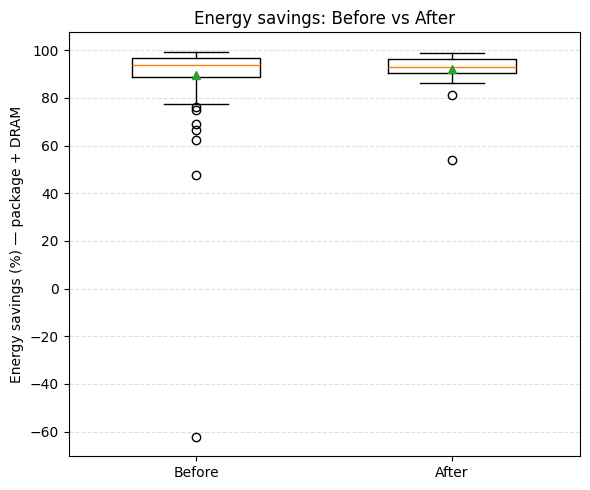

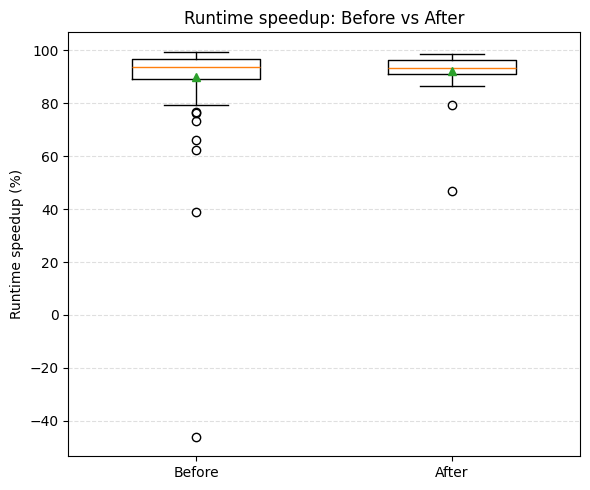

Saved: rq3_energy_savings_boxplot.(pdf|png), rq3_runtime_speedup_boxplot.(pdf|png)


In [8]:
# Energy savings
fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot([paired_before['energy_saving_pct'].dropna(),
            paired_after['energy_saving_pct'].dropna()],
           vert=True, widths=0.5, showmeans=True)
ax.set_xticks([1,2]); ax.set_xticklabels(['Before','After'])
ax.set_ylabel('Energy savings (%) — package + DRAM')
ax.set_title('Energy savings: Before vs After')
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('rq3_energy_savings_boxplot.pdf', bbox_inches='tight')
plt.savefig('rq3_energy_savings_boxplot.png', dpi=200, bbox_inches='tight')
plt.show()

# Runtime speedup
fig, ax = plt.subplots(figsize=(6,5))
ax.boxplot([paired_before['runtime_speedup_pct'].dropna(),
            paired_after['runtime_speedup_pct'].dropna()],
           vert=True, widths=0.5, showmeans=True)
ax.set_xticks([1,2]); ax.set_xticklabels(['Before','After'])
ax.set_ylabel('Runtime speedup (%)')
ax.set_title('Runtime speedup: Before vs After')
ax.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig('rq3_runtime_speedup_boxplot.pdf', bbox_inches='tight')
plt.savefig('rq3_runtime_speedup_boxplot.png', dpi=200, bbox_inches='tight')
plt.show()
print('Saved: rq3_energy_savings_boxplot.(pdf|png), rq3_runtime_speedup_boxplot.(pdf|png)')


## 6) LaTeX table + draft paragraph

In [9]:
import math
def fmt1(x):
    return "NA" if x is None or (isinstance(x,float) and (math.isnan(x))) else f"{x:.1f}"

latex_table = fr"""\begin{{table}}[t]
\centering
\renewcommand{{\arraystretch}}{{1.2}}
\begin{{tabular}}{{lcc}}
\toprule
\textbf{{Metric}} & \textbf{{Before (Median [95\% CI])}} & \textbf{{After (Median [95\% CI])}} \\
\midrule
Energy saving (\%) & {fmt1(medE_b)} [ {fmt1(loE_b)}, {fmt1(hiE_b)} ] & {fmt1(medE_a)} [ {fmt1(loE_a)}, {fmt1(hiE_a)} ] \\
Runtime speedup (\%) & {fmt1(medT_b)} [ {fmt1(loT_b)}, {fmt1(hiT_b)} ] & {fmt1(medT_a)} [ {fmt1(loT_a)}, {fmt1(hiT_a)} ] \\
\bottomrule
\end{{tabular}}
\caption{{RQ3.2 -- Comparison of performance improvements (Python~$\rightarrow$~C++) for benchmarks published before vs after the model's knowledge cut-off. $p$-values from Mann--Whitney U tests: energy {summary['mannwhitney_energy_p']:.3g}, runtime {summary['mannwhitney_runtime_p']:.3g}.}}
\label{{tab:rq3-perf}}
\end{{table}}"""
with open('rq3_2_table.tex','w') as f:
    f.write(latex_table)
print(latex_table)

sb = summary
para = (
    "To assess whether the model's knowledge cut-off affects the magnitude of performance gains, we "
    "compared energy savings and runtime speedups between benchmarks published before and after the cut-off, "
    "using identical pairing and aggregation strategies as in RQ2. "
    f"For energy, the median saving was {sb['energy_saving_before_median_%']:.1f}% "
    f"(95% CI [{sb['energy_saving_before_CI95_%'][0]:.1f}%, {sb['energy_saving_before_CI95_%'][1]:.1f}%]) in the 'Before' group, "
    f"and {sb['energy_saving_after_median_%']:.1f}% "
    f"(95% CI [{sb['energy_saving_after_CI95_%'][0]:.1f}%, {sb['energy_saving_after_CI95_%'][1]:.1f}%]) in the 'After' group. "
    f"For runtime, the median speedup was {sb['runtime_speedup_before_median_%']:.1f}% "
    f"(95% CI [{sb['runtime_speedup_before_CI95_%'][0]:.1f}%, {sb['runtime_speedup_before_CI95_%'][1]:.1f}%]) versus "
    f"{sb['runtime_speedup_after_median_%']:.1f}% "
    f"(95% CI [{sb['runtime_speedup_after_CI95_%'][0]:.1f}%, {sb['runtime_speedup_after_CI95_%'][1]:.1f}%]). "
    f"Mann–Whitney U tests found {'no ' if sb['mannwhitney_energy_p']>=0.05 else ''}evidence of a difference in energy savings "
    f"(p = {sb['mannwhitney_energy_p']:.3g}) and "
    f"{'no ' if sb['mannwhitney_runtime_p']>=0.05 else ''}evidence of a difference in runtime speedup "
    f"(p = {sb['mannwhitney_runtime_p']:.3g})."
)
with open('rq3_2_paragraph.txt','w') as f:
    f.write(para)
print(para)


\begin{table}[t]
\centering
\renewcommand{\arraystretch}{1.2}
\begin{tabular}{lcc}
\toprule
\textbf{Metric} & \textbf{Before (Median [95\% CI])} & \textbf{After (Median [95\% CI])} \\
\midrule
Energy saving (\%) & 93.8 [ 92.3, 94.9 ] & 93.0 [ 91.6, 95.3 ] \\
Runtime speedup (\%) & 93.7 [ 92.4, 95.2 ] & 93.4 [ 91.6, 95.3 ] \\
\bottomrule
\end{tabular}
\caption{RQ3.2 -- Comparison of performance improvements (Python~$\rightarrow$~C++) for benchmarks published before vs after the model's knowledge cut-off. $p$-values from Mann--Whitney U tests: energy 0.712, runtime 0.73.}
\label{tab:rq3-perf}
\end{table}
To assess whether the model's knowledge cut-off affects the magnitude of performance gains, we compared energy savings and runtime speedups between benchmarks published before and after the cut-off, using identical pairing and aggregation strategies as in RQ2. For energy, the median saving was 93.8% (95% CI [92.3%, 94.9%]) in the 'Before' group, and 93.0% (95% CI [91.6%, 95.3%]) in the '